In [18]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
golden_sample_image_path = r'D:\ENO\projects\THT check\tht-assembly-check\golden_images\golden_sample_showcase1.png'
compare_image_path       = r'D:\ENO\projects\THT check\tht-assembly-check\raw_images\showcase_1.png'

golden_sample_image =  cv2.imread(golden_sample_image_path)
compare_image = cv2.imread(compare_image_path)

MIN_AREA = 400000

In [20]:
def filter_contour(contour):
    
    # Unpack points from contour
    points = [item[0] for item in contour]
    # Convert points to np arrays
    points = np.array(points)
    # Get list of coordinates of each axis
    x_axis = points[:, 0]
    y_axis = points[:, 1]

    # Compute and get the two intervals that contain the most coordinates
    def get_interval_by_axis(axis_points, bins=50):
        n, bins, _ = plt.hist(axis_points, bins=bins)
        sort_indices = np.argsort(n)
        bar_delta = bins[1] - bins[0]
        bar_1 = (bins[0] + sort_indices[-1] * bar_delta, bins[0] + (sort_indices[-1] + 1) * bar_delta)
        bar_2 = (bins[0] + sort_indices[-2] * bar_delta, bins[0] + (sort_indices[-2] + 1) * bar_delta)
        max_bars = (  bar_1 ,  bar_2  )
        return max_bars

    # Get the intervals for both axis
    x_intervals = get_interval_by_axis(x_axis)
    y_intervals = get_interval_by_axis(y_axis)

    # Filter the contour points by the intervals
    def filter_contour_by_intervals(points, x_intervals, y_intervals):
        filtered_points = []
        for point in points:
            # If x-coordinate of point is inside any of the x intervals, and y-coordinate of that point does not exceed minumum and maximum of both y intervals
            if   (point[0] > x_intervals[0][0] and point[0] < x_intervals[0][1]) or (point[0] > x_intervals[1][0] and point[0] < x_intervals[1][1]):
                if (point[1] > y_intervals[0][1] and point[1] > y_intervals[1][1]) or (point[1] < y_intervals[0][0] and point[1] < y_intervals[1][0]):
                    continue
                else:
                    filtered_points.append(point)
            # If y-coordinate of point is inside any of the y intervals, and x-coordinate of that point does not exceed minumum and maximum of both x intervals
            elif (point[1] > y_intervals[0][0] and point[1] < y_intervals[0][1]) or (point[1] > y_intervals[1][0] and point[1] < y_intervals[1][1]):
                if (point[0] > x_intervals[0][1] and point[0] > x_intervals[1][1]) or (point[0] < x_intervals[0][0] and point[0] < x_intervals[1][0]):
                    continue
                else:
                    filtered_points.append(point)
        return np.array(filtered_points)

    filtered_points = filter_contour_by_intervals(points, x_intervals, y_intervals)

    # Zip the points into the format of contour points
    filtered_contour = [ [point] for point in filtered_points]
    filtered_contour = np.array(filtered_contour)

    return filtered_contour

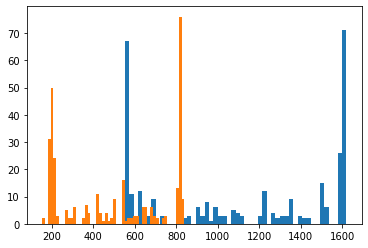

In [21]:
image_raw = compare_image
hsv_image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2HSV)
# define range of blue color in HSV
lower_blue = np.array([45, 20, 0])
upper_blue = np.array([150, 150, 255])
# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
# Bitwise-AND mask and original image
res = cv2.bitwise_and(image_raw, image_raw, mask=mask)
hsv_thres = cv2.adaptiveThreshold(cv2.cvtColor(res, cv2.COLOR_BGR2GRAY), 255,
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 301, 0)
kernel_for_opening = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
kernel_for_closing = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
open_gray = cv2.morphologyEx(hsv_thres, cv2.MORPH_OPEN, kernel_for_opening, iterations=1)
close_gray = cv2.morphologyEx(open_gray, cv2.MORPH_CLOSE, kernel_for_closing, iterations=3)
(contours, _) = cv2.findContours(close_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
my_single_contour = None

contours = [contour for contour in contours if cv2.contourArea(contour) > MIN_AREA]
if len(contours) > 1:
    print('Find more than one contour of PCB area. Consider modify MIN_AREA parameter.')
    for contour in contours:
        print(f'contour found with area {cv2.contourArea(contour)}.')
my_single_contour = contours[0]
my_single_contour = filter_contour(my_single_contour)
(upper_left_x, upper_left_y) = my_single_contour.reshape(-1, 2).min(0)
(lower_right_x, lower_right_y) = my_single_contour.reshape(-1, 2).max(0)
pcb_width = lower_right_x - upper_left_x
pcb_heigth = lower_right_y - upper_left_y
cavas_width = int(pcb_width*1.1)
cavas_height = int(pcb_heigth*1.1)
canvas = 0 * np.ones(shape=[cavas_height, cavas_width, 3], dtype=np.uint8)
canvas[0:pcb_heigth, 0:pcb_width, :] = image_raw[upper_left_y:lower_right_y, upper_left_x:lower_right_x, :]

# plt.figure(figsize=(20,20))
# ax = plt.subplot(3,1,1)
# plt.imshow(image_raw)
# ax = plt.subplot(3,1,2)
# plt.imshow(golden_sample_image)


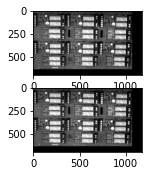

In [22]:
compared_image = cv2.cvtColor(canvas, cv2.COLOR_BGR2GRAY)
golden_sample_image = cv2.cvtColor(golden_sample_image, cv2.COLOR_BGR2GRAY)
ax = plt.subplot(3,1,1)
plt.imshow(golden_sample_image, cmap='gray')
ax = plt.subplot(3,1,2)
plt.imshow(compared_image, cmap='gray')


In [23]:
plt.figure(figsize=(20,20))

PIXEL_DIFFERENCE_OF_MATCH_POINTS = 10
TOP_MATCH_RATE = 0.05
sift = cv2.xfeatures2d.SIFT_create()
padded_compared_image = np.zeros(golden_sample_image.shape, dtype=np.uint8)
padded_compared_image[0:compared_image.shape[0], 0:compared_image.shape[1]] = compared_image
print(padded_compared_image[0])

keypoints_compared_image, description_compared_image = sift.detectAndCompute(compared_image, None)
keypoints_golden_image, description_golden_image = sift.detectAndCompute(golden_sample_image, None)
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(description_compared_image, description_golden_image, k=1)
knn_matches.sort(key=lambda x: x[0].distance, reverse=False)
numGoodMatches = int(len(knn_matches) * TOP_MATCH_RATE)
pending_top_matches = [x[0] for x in knn_matches[:numGoodMatches]]
print(f'pending top match qty is {len(pending_top_matches)}')
good_matches = []
for match in pending_top_matches:
    x1 = keypoints_compared_image[match.queryIdx].pt[0]
    y1 = keypoints_compared_image[match.queryIdx].pt[1]
    x2 = keypoints_golden_image[match.trainIdx].pt[0]
    y2 = keypoints_golden_image[match.trainIdx].pt[1]
    # the axis of match points should be very very similar/close.
    if abs(x1-x2) < PIXEL_DIFFERENCE_OF_MATCH_POINTS and abs(y1-y2) < PIXEL_DIFFERENCE_OF_MATCH_POINTS:
        good_matches.append(match)
print(f'Final good matches qty : {len(good_matches)}')
if len(good_matches) < 10:
    print('Too few good match points.')
    raise Exception
# -- Localize the object
obj = np.empty((len(good_matches), 2), dtype=np.float32)
scene = np.empty((len(good_matches), 2), dtype=np.float32)
for i in range(len(good_matches)):
    # -- Get the keypoints from the good matches
    obj[i, 0] = keypoints_compared_image[good_matches[i].queryIdx].pt[0]
    obj[i, 1] = keypoints_compared_image[good_matches[i].queryIdx].pt[1]
    scene[i, 0] = keypoints_golden_image[good_matches[i].trainIdx].pt[0]
    scene[i, 1] = keypoints_golden_image[good_matches[i].trainIdx].pt[1]
H, _ = cv2.findHomography(obj, scene, cv2.RANSAC)
golden_sample_gray_height, golden_sample_gray_width = golden_sample_image.shape
compared_image_after_alignment = cv2.warpPerspective(
    canvas, H, (golden_sample_gray_width, golden_sample_gray_height))

[63 64 65 ...  0  0  0]
pending top match qty is 221
Final good matches qty : 221


<Figure size 1440x1440 with 0 Axes>

(691, 1172, 3)


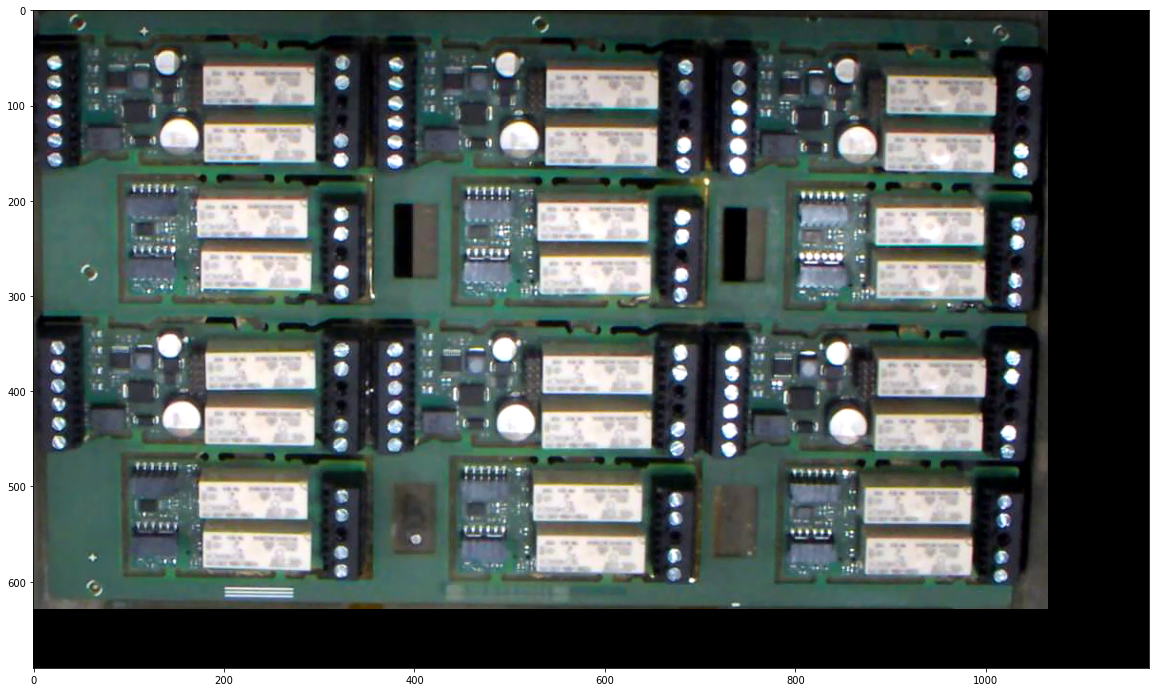

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(compared_image_after_alignment, cv2.COLOR_BGR2RGB))
print(compared_image_after_alignment.shape)